# Seasonal Decompose

An example of how to decompose time series into trend, seasonal, and residual components.
It uses the function within the ProcessData class from the COAsT package that will decompose time series into trend, seasonal and residual components. The function is a wrapper that adds functionality to the `seasonal_decompose` function contained in the [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose) package to make it more convenient for large geospatial datasets.

Specifically:
1) Multiple time series spread across multiple dimensions, e.g. a gridded dataset, can be processed. The user simply passes in an xarray DataArray that has a "t_dim" dimension and 1 or more additional dimensions, for example gridded spatial dimensions
2) Masked locations, such as land points, are handled
3) The decomposed time series are returned as xarray DataArrays within a single coast.Gridded object

## An example
Below is an example using the `coast.ProcessData.seasonal_decomposition` function with the example data. Note that we will artifically extend the length of the example data time series for demonstrative purposes.

Begin by importing coast, defining paths to the data, and loading the example data into a gridded object:

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [40]:
import coast
import numpy as np
import xarray as xr
import glob

In [8]:
root = "../../"
dn_files = root + "./example_files/"

fn_nemo_dat  = dn_files + "coast_example_nemo_data.nc"
# Set path for domain file if required.
fn_nemo_dom  = dn_files + "coast_example_nemo_domain.nc"
# Set path for model configuration file
config = root + "./config/example_nemo_grid_t.json"

# Read in data (This example uses NEMO data.)
grd1 = coast.Gridded(fn_nemo_dat, fn_nemo_dom, config=config)

In [5]:
data_path = "/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1"
fn_nemo_dom = "/gws/nopw/j04/canari/users/dlrhodso/mesh_mask.nc"
config_t = "../../config/example_nemo_grid_t.json"
years = ['2010', '2011', '2012', '2013']

data_files = []
for year in years:
    infiles = glob.glob((f"{data_path}/OCN/yearly/{year}/*_votemper.nc"))
    for infile in infiles:
        data_files.append(infile)

In [6]:
fn_nemo_dat = xr.open_mfdataset(data_files)
grd = coast.Gridded(fn_data=fn_nemo_dat,
                          fn_domain=fn_nemo_dom,
                          config=config_t,
                          )

The loaded example data only has 7 time stamps, the code below creates a new (fake) extended temperature variable with 48 monthly records. This code is not required to use the function, it is only included here to make a set of time series that are long enough to be interesting.

Subsetting data by depth

In [18]:
grd = grd.isel(z_dim=[0,1])

In [20]:
temperature = grd.dataset.temperature

In [21]:
temperature

<xarray.DataArray 'temperature' (t_dim: 48, z_dim: 2, y_dim: 1207, x_dim: 1442)> Size: 668MB
dask.array<getitem, shape=(48, 2, 1207, 1442), dtype=float32, chunksize=(1, 2, 302, 361), chunktype=numpy.ndarray>
Coordinates:
  * time       (t_dim) object 384B 2010-01-16 00:00:00 ... 2013-12-16 00:00:00
  * y          (y_dim) float64 10kB 0.0 1.0 2.0 ... 1.205e+03 1.206e+03
  * x          (x_dim) float64 12kB 0.0 1.0 2.0 ... 1.439e+03 1.44e+03 1.441e+03
    longitude  (y_dim, x_dim) float32 7MB ...
    latitude   (y_dim, x_dim) float32 7MB ...
    depth_0    (z_dim, y_dim, x_dim) float64 28MB 0.5 0.5 0.5 ... 1.55 1.55 1.55
Dimensions without coordinates: t_dim, z_dim, y_dim, x_dim
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           Sea Water Potential Temperature
    units:               degree_C
    online_operation:    average
    interval_operation:  1 month
    interval_write:      1 month
    cell_measures:       area: areacello
    cell_methods:        time_counter: mean

Check out the new data

In [6]:
#temperature # uncomment to print data object summary

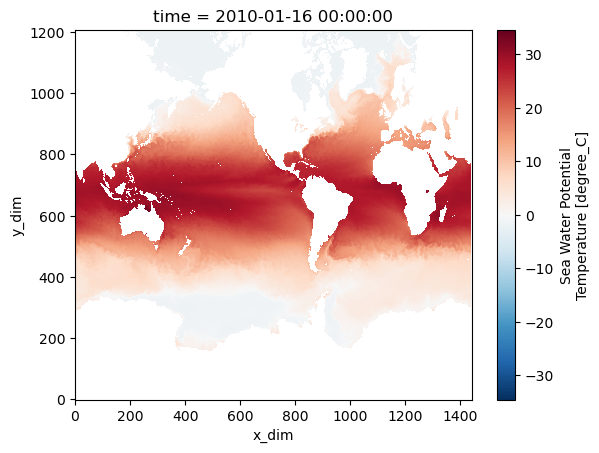

In [22]:
temperature[0,0,:,:].plot()

Check out time series at 2 different grid points

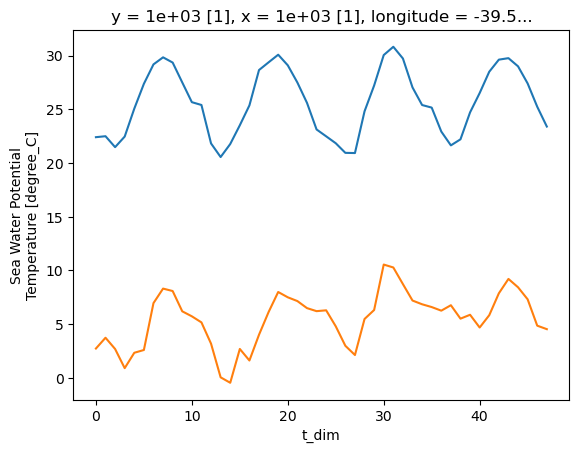

In [33]:
temperature[:,0,800,800].plot()
temperature[:,0,1000,1000].plot()

Create a `coast.Process_data` object, and call the `seasonal_decomposition` function, passing in the required arguments. The first two arguments are:
1. The input data, here the temperature data as an xarray DataArray
2. The number of chuncks to split the data into. Here we split the data into 2 chunks so that the dask scheduler will try to run 4 processes in parallel

The remaining arguments are keyword arguments for the underlying `statsmodels.tsa.seasonal.seasonal_decompose` function, which are documented on the [statsmodels documentation pages](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose).  Here we specify:

3. three The type of model, i.e. an additive model
4. The period of the seasonal cycle, here it is 6 months
5. Extrapolate the trend component to cover the entire range of the time series (this is required because the trend is calculated using a convolution filter) 


In [35]:
proc_data = coast.ProcessData()
grd = proc_data.seasonal_decomposition(temperature, 2, model="additive", period=6, extrapolate_trend="freq")

/home/users/tobfer/miniconda3/envs/canarisprint/lib/python3.10/site-packages/coast/_utils/process_data.py:114: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
/home/users/tobfer/miniconda3/envs/canarisprint/lib/python3.10/site-packages/coast/_utils/process_data.py:116: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
/home/users/tobfer/miniconda3/envs/canarisprint/lib/python3.10/site-packages/coast/_utils/process_data.py:118: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.


The returned xarray Dataset contains the decomposed time series (trend, seasonal, residual) as dask arrays

In [36]:
grd.dataset # uncomment to print data object summary

<xarray.Dataset> Size: 2GB
Dimensions:    (t_dim: 48, y_dim: 1207, x_dim: 1442, z_dim: 2)
Coordinates:
  * time       (t_dim) object 384B 2010-01-16 00:00:00 ... 2013-12-16 00:00:00
  * y          (y_dim) float64 10kB 0.0 1.0 2.0 ... 1.205e+03 1.206e+03
  * x          (x_dim) float64 12kB 0.0 1.0 2.0 ... 1.439e+03 1.44e+03 1.441e+03
    longitude  (y_dim, x_dim) float32 7MB dask.array<chunksize=(1207, 1442), meta=np.ndarray>
    latitude   (y_dim, x_dim) float32 7MB dask.array<chunksize=(1207, 1442), meta=np.ndarray>
    depth_0    (z_dim, y_dim, x_dim) float64 28MB dask.array<chunksize=(1, 1207, 1442), meta=np.ndarray>
Dimensions without coordinates: t_dim, y_dim, x_dim, z_dim
Data variables:
    trend      (t_dim, z_dim, y_dim, x_dim) float32 668MB dask.array<chunksize=(48, 1, 1207, 1442), meta=np.ndarray>
    seasonal   (t_dim, z_dim, y_dim, x_dim) float32 668MB dask.array<chunksize=(48, 1, 1207, 1442), meta=np.ndarray>
    residual   (t_dim, z_dim, y_dim, x_dim) float32 668MB dask.array<chunksize=(48, 1, 1207, 1442), meta=np.ndarray>

Execute the computation

In [37]:
grd.dataset.compute()

<xarray.Dataset> Size: 2GB
Dimensions:    (t_dim: 48, y_dim: 1207, x_dim: 1442, z_dim: 2)
Coordinates:
  * time       (t_dim) object 384B 2010-01-16 00:00:00 ... 2013-12-16 00:00:00
  * y          (y_dim) float64 10kB 0.0 1.0 2.0 ... 1.205e+03 1.206e+03
  * x          (x_dim) float64 12kB 0.0 1.0 2.0 ... 1.439e+03 1.44e+03 1.441e+03
    longitude  (y_dim, x_dim) float32 7MB 72.75 73.0 73.25 ... 73.01 73.0 73.0
    latitude   (y_dim, x_dim) float32 7MB -89.5 -89.5 -89.5 ... 50.02 50.0 50.0
    depth_0    (z_dim, y_dim, x_dim) float64 28MB 0.5 0.5 0.5 ... 1.55 1.55 1.55
Dimensions without coordinates: t_dim, y_dim, x_dim, z_dim
Data variables:
    trend      (t_dim, z_dim, y_dim, x_dim) float32 668MB nan nan ... nan nan
    seasonal   (t_dim, z_dim, y_dim, x_dim) float32 668MB nan nan ... nan nan
    residual   (t_dim, z_dim, y_dim, x_dim) float32 668MB nan nan ... nan nan

Plot the decomposed time series

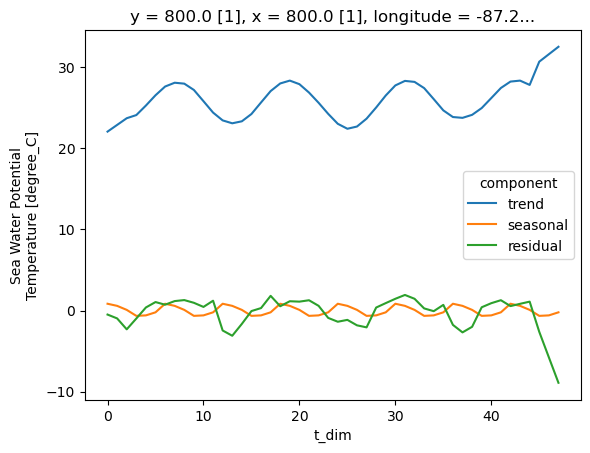

In [39]:
component = xr.DataArray( ["trend","seasonal","residual"], dims="component", name="component" )
temp_decomp = xr.concat( 
    [grd.dataset.trend, grd.dataset.seasonal,grd.dataset.residual], dim=component 
)
temp_decomp.name = "temperature"
temp_decomp[:,:,0,800,800].plot(hue="component")